In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import statsmodels.api as sm
from arch import arch_model
sns.set()
%matplotlib inline

In [2]:
import pandas_datareader.data as web
start = dt.datetime(1990, 1, 1)
end = dt.datetime(2018, 11, 6)
sp500 = web.get_data_yahoo('^GSPC', start=start, end=end)
vix_data = web.get_data_yahoo('^VIX', start=start, end=end)
vix_data = vix_data['Close'].round(2)

vix_ret = vix_data.pct_change().dropna()
sp_ret = 100*sp500['Adj Close'].pct_change().dropna()

In [3]:
# Split the train and test set by 80-20 rule
n = len(vix_ret)
n_train = int(n * 0.8)
n_test = n - n_train

X_train = vix_ret[:n_train]
X_test = vix_ret[n_train:]
split_date = X_test.index[0]
print('No. train:', n_train)
print('No. test:', n_test)
print('Split date:', split_date)

No. train: 5816
No. test: 1455
Split date: 2013-01-31 00:00:00


In [4]:
%%time
# Use K-means clustering to define the spike in VIX
from sklearn.cluster import KMeans
n_clusters = 4

# Find the best kmeans with the minimum sum of square distances
num_seed = 100
ssd = np.zeros(num_seed)
for i in range(num_seed):
    if i % 20 == 0:
        print(i)
    kmeans = KMeans(n_clusters=n_clusters, random_state=i).fit(X_train.values.reshape(-1,1))
    ssd[i] = kmeans.inertia_
best_seed = ssd.argmin()
best_kmeans = KMeans(n_clusters=n_clusters, random_state=best_seed).fit(X_train.values.reshape(-1,1))

0
20
40
60
80
CPU times: user 11.9 s, sys: 466 ms, total: 12.3 s
Wall time: 13 s


In [5]:
# Find the boundaries of four state of VIX Returns
center = best_kmeans.cluster_centers_.copy()
print('center:', center)
center.sort(axis = 0)
boundary = (center[1:] + center[:-1])/2
print('boundary:', boundary)

center: [[ 0.05312938]
 [-0.00824458]
 [ 0.17563852]
 [-0.07121144]]
boundary: [[-0.03972801]
 [ 0.0224424 ]
 [ 0.11438395]]


In [6]:
train_label = best_kmeans.labels_
test_label = best_kmeans.predict(X_test.values.reshape(-1,1))

spike_label = best_kmeans.cluster_centers_.argmax()

# Label the spike as 1, other states as 0

# The first label should be removed because we can lose the first predicted vol returns
# when we use the predicted vol to calculate the predicted vol returns
y_train = train_label[1:].copy()
y_train[y_train != spike_label] = 0
y_train[y_train == spike_label] = 1


# The first label should be removed because we can lose the first predicted vol returns
# when we use the predicted vol to calculate the predicted vol returns

# The second label should also be removed because the model can only give us predicted vol
# without the first out-of-sample prediction
y_test = test_label[2:].copy()
y_test[y_test != spike_label] = 0
y_test[y_test == spike_label] = 1

In [7]:
print('Training set total:', len(y_train))
print('Training set 0:', len(y_train)-y_train.sum())
print('Training set 1:', y_train.sum())
print('Test set total:', len(y_test))
print('Test set 0:', len(y_test)-y_test.sum())
print('Test set 1:', y_test.sum())
print('Total 0:', len(y_train)-y_train.sum()+len(y_test)-y_test.sum())
print('Total 1:', y_train.sum()+y_test.sum())
print('Total:', len(y_train) + len(y_test))

Training set total: 5815
Training set 0: 5574
Training set 1: 241
Test set total: 1453
Test set 0: 1355
Test set 1: 98
Total 0: 6929
Total 1: 339
Total: 7268


Text(0, 0.5, 'VIX Returns')

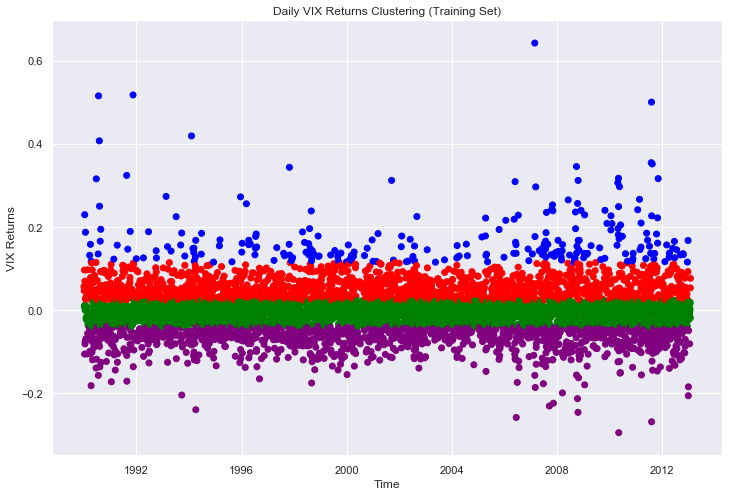

In [8]:
# Plot the clustering result in the training set
import matplotlib
colors = ['red','green','blue','purple']
plt.figure(figsize=(12,8))
plt.scatter(X_train.index, X_train.values, c=train_label, cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Daily VIX Returns Clustering (Training Set)')
plt.xlabel('Time')
plt.ylabel('VIX Returns')

Text(0, 0.5, 'VIX Returns')

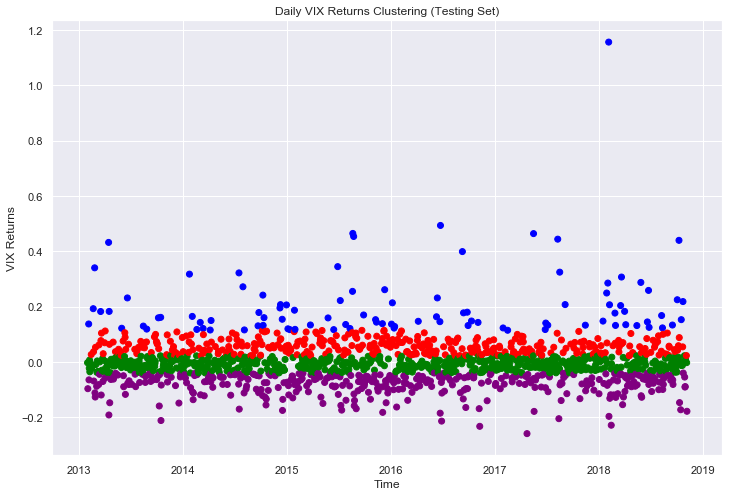

In [9]:
# Plot the clustering result in the testing set
colors = ['red','green','blue','purple']
plt.figure(figsize=(12,8))
plt.scatter(X_test.index, X_test.values, c=test_label, cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Daily VIX Returns Clustering (Testing Set)')
plt.xlabel('Time')
plt.ylabel('VIX Returns')

## Fit the GARCH model

In [46]:
# Fit the GARCH(1,1) model to the sp500 returns
garch = arch_model(sp_ret, vol='GARCH', p=2, o=0, q=2, dist='Normal')
# garch = arch_model(sp_ret, vol='GARCH', p=1, o=0, q=1, dist='Normal')
res = garch.fit(last_obs=split_date, disp='off')

# GARCH model summary
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -7924.73
Distribution:                  Normal   AIC:                           15861.5
Method:            Maximum Likelihood   BIC:                           15901.5
                                        No. Observations:                 5816
Date:                Thu, Nov 29 2018   Df Residuals:                     5810
Time:                        15:26:48   Df Model:                            6
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0558  1.071e-02      5.213  1.860e-07 [3.

Text(0.5, 1.0, 'VIX vs GARCH Predicted Volatility')

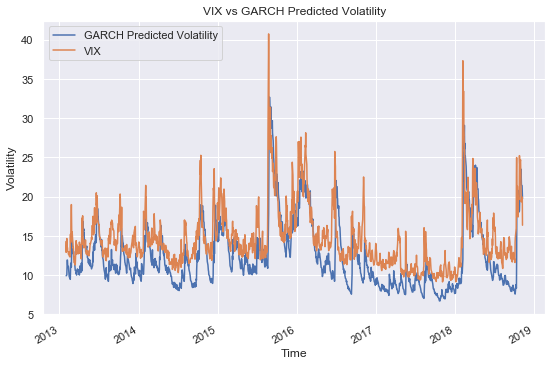

In [47]:
# Use GARCH model to predict conditional volatility
forecasts = res.forecast(horizon=1, start=split_date)
pred_vol = np.sqrt(forecasts.variance[split_date:].shift(1)['h.1'])

# # GARCH model parameters
# omega = res.params['omega']
# alpha = res.params['alpha[1]']
# beta = res.params['beta[1]']
# mu = res.params['mu']

# # Fill the first one-step forecast 
# last_con_vol = res.conditional_volatility[:split_date][-2]
# last_resi = res.resid[:split_date][-2]
# con_vol = np.sqrt(omega + alpha * last_resi**2 + beta * last_con_vol**2)
# pred_vol[split_date] = con_vol

# Annualize the GARCH predicted volatility
p_vol = pred_vol*np.sqrt(252)

# Plot the VIX and GARCH predicted volatility
p_vol.plot(figsize=(9,6))
vix_data[split_date:].plot(figsize=(9,6))
plt.ylabel('Volatility')
plt.xlabel('Time')
plt.legend(['GARCH Predicted Volatility', 'VIX'], loc='upper left')
plt.title('VIX vs GARCH Predicted Volatility')

In [48]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score

# predicted label in the testing set
pred_vix_ret = p_vol.pct_change().dropna()
pred_label = best_kmeans.predict(pred_vix_ret.values.reshape(-1,1))
pred_label[pred_label != spike_label] = 0
pred_label[pred_label == spike_label] = 1

# Compute the classification metrics
# y_test = true_label
# y_score = pred_vix_ret
# auc_pr = average_precision_score(y_test, pred_vix_ret)

# print('Average Precision Score:', auc_pr)
print('Recall:', recall_score(y_test, pred_label))
print('Precision:', precision_score(y_test, pred_label))
print(classification_report(y_test, pred_label))

Recall: 0.11224489795918367
Precision: 0.12087912087912088
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1355
           1       0.12      0.11      0.12        98

   micro avg       0.89      0.89      0.89      1453
   macro avg       0.53      0.53      0.53      1453
weighted avg       0.88      0.89      0.88      1453



In [62]:
# Fit the EGARCH model 
egarch = arch_model(sp_ret, p=2, o=0, q=2, vol='EGARCH')
res = egarch.fit(last_obs=split_date, disp='off')

# EGARCH model summary
print(res.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:              Adj Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                     EGARCH   Log-Likelihood:               -7932.88
Distribution:                  Normal   AIC:                           15877.8
Method:            Maximum Likelihood   BIC:                           15917.8
                                        No. Observations:                 5816
Date:                Thu, Nov 29 2018   Df Residuals:                     5810
Time:                        16:48:22   Df Model:                            6
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0513  1.080e-02      4.749  2.049e-06 [3.

Text(0.5, 1.0, 'VIX vs EGARCH Predicted Volatility')

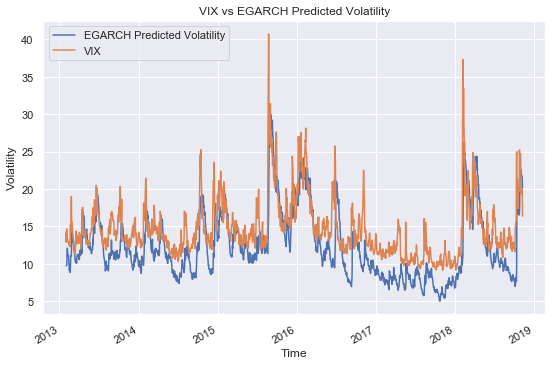

In [63]:
# Use EGARCH model to predict conditional volatility
forecasts = res.forecast(horizon=1, start=split_date, method='bootstrap')
pred_vol = np.sqrt(forecasts.variance[split_date:].shift(1)['h.1'])

# Annualize the EGARCH predicted volatility
p_vol = pred_vol*np.sqrt(252)

# Plot the VIX and GARCH predicted volatility
p_vol.plot(figsize=(9,6))
vix_data[split_date:].plot(figsize=(9,6))
plt.ylabel('Volatility')
plt.xlabel('Time')
plt.legend(['EGARCH Predicted Volatility', 'VIX'], loc='upper left')
plt.title('VIX vs EGARCH Predicted Volatility')

In [64]:
# predicted label in the testing set
pred_vix_ret = p_vol.pct_change().dropna()
pred_label = best_kmeans.predict(pred_vix_ret.values.reshape(-1,1))
pred_label[pred_label != spike_label] = 0
pred_label[pred_label == spike_label] = 1

# Compute the classification metrics
# y_test = true_label
# y_score = pred_vix_ret
# auc_pr = average_precision_score(y_test, pred_vix_ret)

# print('Average Precision Score:', auc_pr)
print('Recall:', recall_score(y_test, pred_label))
print('Precision:', precision_score(y_test, pred_label))
print(classification_report(y_test, pred_label))

Recall: 0.10204081632653061
Precision: 0.11235955056179775
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1355
           1       0.11      0.10      0.11        98

   micro avg       0.89      0.89      0.89      1453
   macro avg       0.52      0.52      0.52      1453
weighted avg       0.88      0.89      0.88      1453



In [17]:
# AR(1) + GARCH(1,1)
from arch.univariate import ARX
from arch.univariate import GARCH
ar_garch = ARX(sp_ret, lags=[1])
ar_garch.volatility = GARCH(p=1, q=1)
res = ar_garch.fit(last_obs=split_date, disp='off')

# Model summary
print(res.summary())

                           AR - GARCH Model Results                           
Dep. Variable:              Adj Close   R-squared:                       0.001
Mean Model:                        AR   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -7936.34
Distribution:                  Normal   AIC:                           15882.7
Method:            Maximum Likelihood   BIC:                           15916.0
                                        No. Observations:                 5815
Date:                Thu, Nov 29 2018   Df Residuals:                     5810
Time:                        14:07:04   Df Model:                            5
                                   Mean Model                                  
                   coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------------
Const            0.0560  1.083e-02      5.170  2.

Text(0.5, 1.0, 'VIX vs AR-GARCH Predicted Volatility')

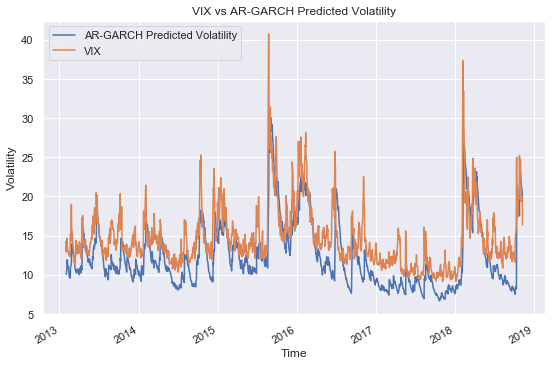

In [18]:
# Use the model to predict conditional volatility
forecasts = res.forecast(horizon=1, start=split_date)
pred_vol = np.sqrt(forecasts.variance[split_date:].shift(1)['h.1'])

# Annualize the predicted volatility
p_vol = pred_vol*np.sqrt(252)

# Plot the VIX and GARCH predicted volatility
p_vol.plot(figsize=(9,6))
vix_data[split_date:].plot(figsize=(9,6))
plt.ylabel('Volatility')
plt.xlabel('Time')
plt.legend(['AR-GARCH Predicted Volatility', 'VIX'], loc='upper left')
plt.title('VIX vs AR-GARCH Predicted Volatility')

In [19]:
# predicted label in the testing set
pred_vix_ret = p_vol.pct_change().dropna()
pred_label = best_kmeans.predict(pred_vix_ret.values.reshape(-1,1))
pred_label[pred_label != spike_label] = 0
pred_label[pred_label == spike_label] = 1

# Compute the classification metrics
# y_test = true_label
# y_score = pred_vix_ret
# auc_pr = average_precision_score(y_test, pred_vix_ret)

# print('Average Precision Score:', auc_pr)
print('Recall:', recall_score(y_test, pred_label))
print('Precision:', precision_score(y_test, pred_label))
print(classification_report(y_test, pred_label))

Recall: 0.07142857142857142
Precision: 0.11864406779661017
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1355
           1       0.12      0.07      0.09        98

   micro avg       0.90      0.90      0.90      1453
   macro avg       0.53      0.52      0.52      1453
weighted avg       0.88      0.90      0.89      1453

